![datiaperti logo](images/datiaperti_small.png)

# Geospatial Data Analysis - Vector Data
This notebook is about GDAL/OGR, a library for vector geospatial data formats used to traslate one format to another among those supported. GDAL is written in C/C++ with bindings in other languages such as Python and Java. GDAL also provides a set of programs that can be used from the command line. Install the gdal package before using this notebook  

$ conda install -c conda-forge gdal  

$ conda install -c conda-forge pyshp  

Use [GDAL/OGR Cookbook](https://pcjericks.github.io/py-gdalogr-cookbook/index.html) for references.

In [105]:
import os
import sys
import struct
import zipfile
from shapely import wkt, geometry
import fiona
import geopandas as gpd
import pyproj
import pandas as pd
import numpy as np
#import utm
import shapefile as shp
from osgeo import gdal_array
from osgeo import ogr, osr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline
print("shapefile version: %s"%shp.__version__)

shapefile version: 2.3.0


## Compressed files
### Zip

In [2]:
zip = open("data/vector/US/us_census.zip", "rb")
zipShape = zipfile.ZipFile(zip)
for fileName in zipShape.namelist():
    print(fileName)
    #out = open('data/vector/US/' + fileName, "wb")
    #out.write(zipShape.read(fileName))
    #out.close()

ACSST1Y2021.S1901-Data.csv
ACSST1Y2021.S1901-Column-Metadata.csv
ACSST1Y2021.S1901-Table-Notes.txt


## Vector Data
### Esri shape file
The Esri shapefile format has a fixed location and data type in the file header from byte 36 to byte 37 for the minimum x, minimum y, maximum x, and maximum y bounding box values.

In [3]:
path = os.path.relpath("data/vector/stbnd/stbnd.shp")
f = open(path,"rb")
f.seek(36) 
struct.unpack("<d", f.read(8)) # min x

(318573.31825141667,)

In [4]:
struct.unpack("<d", f.read(8)) # min y

(1035233.9673716214,)

In [5]:
struct.unpack("<d", f.read(8)) # max x

(651004.9840024861,)

In [6]:
struct.unpack("<d", f.read(8)) # max y

(1577852.5200537047,)

### GeoJSON

In [7]:
gc = { "type": "GeometryCollection",
       "geometries": [
          { "type": "Point",
            "coordinates": [-89.33, 30.0]
          },
          { "type": "LineString",
            "coordinates": [ [-89.33, 30.30], [-89.36, 30.28] ]
          }
       ]
}

In [8]:
gc

{'type': 'GeometryCollection',
 'geometries': [{'type': 'Point', 'coordinates': [-89.33, 30.0]},
  {'type': 'LineString', 'coordinates': [[-89.33, 30.3], [-89.36, 30.28]]}]}

## Geospatial Python Toolbox
### Shapely
It is a generic geometry library, a Python port of the [Java Topology Suite](https://github.com/locationtech/jts) that provides support fot topology operators for geometric objects. 

In [9]:
wktSquare = "POLYGON((0 0,4 0,4 4,0 4,0 0))" # a square on a 2D reference system
square = wkt.loads(wktSquare)
square.area

16.0

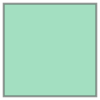

In [10]:
square

We check whether a point lies within the square

In [11]:
wktPoint = 'POINT (2 2)'
point = wkt.loads(wktPoint)
point.within(square)

True

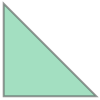

In [12]:
wktTriangle = 'POLYGON((2 2, 3 2, 2 3, 2 2))'
triangle = wkt.loads(wktTriangle)
triangle

We check whether the triangle lies within the square

In [13]:
triangle.within(square)

True

### Fiona
A simple Python API around the OGR library for data access.

In [14]:
shp_file_name = 'data/vector/US/cities_albers.shp'

In [15]:
f = fiona.open(shp_file_name)
f.driver

'ESRI Shapefile'

In [16]:
f.crs

{}

In [17]:
f.bounds # pairs of geo coordinates that define a bounding box) 

(-6282848.754867505,
 -62785.72259264253,
 3393444.0014464697,
 6186491.5102767795)

In [18]:
len(list(f)) # number of polygongs in the shape file

35432

In [19]:
print(f[44])

{'type': 'Feature', 'id': '44', 'properties': OrderedDict([('CITIESX020', 45), ('FEATURE', 'Populated Place'), ('NAME', 'Anvik'), ('POP_RANGE', '0 - 9,999'), ('POP_2000', 104), ('FIPS55', '03880'), ('COUNTY', 'Yukon-Koyukuk Census Area'), ('FIPS', '02290'), ('STATE', 'AK'), ('STATE_FIPS', '02'), ('DISPLAY', 0)]), 'geometry': {'type': 'Point', 'coordinates': (-3510436.406032449, 5549048.212929771)}}


### GeoPandas

<AxesSubplot:>

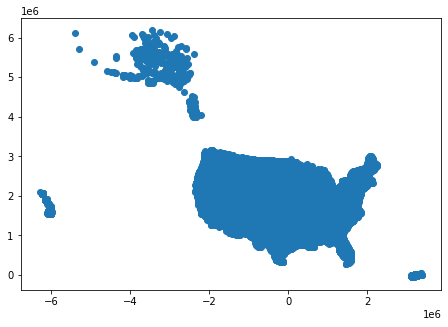

In [20]:
gdf = gpd.GeoDataFrame
census = gdf.from_file('data/vector/US/cities_albers.shp')
fig, ax = plt.subplots(1, figsize=(10, 5))
census.plot(ax=ax)

In [21]:
r = shp.Reader(shp_file_name)
r.bbox # pairs of coordinates of two points used to define a bounding box (min_xm, min_y, max_x, max_y)

[-6282848.754867505, -62785.72259264253, 3393444.0014464697, 6186491.5102767795]

In [22]:
r.numRecords # number of polygons in the shape file

35432

In [23]:
r.shapeType # 5 means polygons

1

In [24]:
[item[0] for item in r.fields[1:]] # record fields

['CITIESX020',
 'FEATURE',
 'NAME',
 'POP_RANGE',
 'POP_2000',
 'FIPS55',
 'COUNTY',
 'FIPS',
 'STATE',
 'STATE_FIPS',
 'DISPLAY']

In [25]:
r.record(2)

Record #2: [3, 'Populated Place', 'Point Lay', 'Undetermined', -99999, '61700', 'North Slope Borough', '02185', 'AK', '02', 1]

### GDAL library

We use the OGR module to work with vector data. It provides a unique interface to read and write data in different formats such as Esri shape file, GeoJSON and many other. A dataset in OGR contains one layer that can contain one or more features. A layer also contains information such as the coordinate system that are used for the coordinates of the features. A feature is a geographic object: a point, a line or a polygon. A feature has attributes, one of this is its geometry. 

In [28]:
fn = 'data/vector/global/ne_50m_populated_places.shp'
ds = ogr.Open(fn, 0) # open in read-only mode
if ds is None:
    sys.exit('Could not open {0}.'.format(fn))
layer = ds.GetLayer(0)
num_features = layer.GetFeatureCount()
i = 0
for feature in layer:  # a feature is a geographic object: a point, a line or a polygon.
    pt = feature.geometry()
    x = pt.GetX()
    y = pt.GetY()
    name = feature.GetField('NAME')
    pop = feature.GetField('POP_MAX')
    print(name, pop, x, y)
    i += 1
    if i == 10:
        break
del ds
print(num_features)

Bombo 75000 32.533299524864844 0.5832991056146284
Fort Portal 42670 30.27500161597942 0.671004121125236
Potenza 69060 15.798996495640267 40.642002130098206
Campobasso 50762 14.655996558921856 41.56299911864397
Aosta 34062 7.315002595706176 45.7370010670723
Mariehamn 10682 19.949004471869102 60.09699618489543
Ramallah 24599 35.206209378189556 31.90294475142406
Vatican City 832 12.453386544971766 41.903282179960115
Poitier 85960 0.3332765285345545 46.58329225573658
Clermont-Ferrand 233050 3.080008095928406 45.779982115759424
1249


Print the west and east longitude and the south and nord latitude of the bounding box that contains all the features in the a layer.

In [29]:
ds = ogr.Open('data/vector/Washington/large_cities.geojson')
layer = ds.GetLayer(0)
extent = layer.GetExtent()
print(extent)

(-122.66148376464844, -117.4260482788086, 45.638729095458984, 48.759552001953125)


We can read the layer's coordinate system that is used by the features

In [30]:
print(layer.GetSpatialRef())

GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS 1980",6378137,298.257222101,
            AUTHORITY["EPSG","7019"]],
        AUTHORITY["EPSG","6269"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4269"]]


We print the attributes (fields) used for the features

In [31]:
for field in layer.schema:
    print(field.name, field.GetTypeName())

CITIESX020 Integer
FEATURE String
NAME String
POP_RANGE String
POPULATION Integer
FIPS55 String
COUNTY String
FIPS String
STATE String
STATE_FIPS String
DISPLAY Integer


Let's see the 1st feature's type of the layer

In [32]:
feature0 = layer.GetFeature(0)
print(feature0.geometry().GetGeometryName())

POINT


now we can close the datasource

In [33]:
del ds

We create a new shape file copying the structure of another shape file.

In [34]:
ds = ogr.Open('data/vector/global/ne_50m_populated_places.shp', 1)
if ds is None:
    sys.exit('Could not open folder.')
in_lyr = ds.GetLayer()
#for field in in_lyr.schema:
#    print(field.name, field.GetTypeName())

In [35]:
if ds.GetLayer('capital_cities'):
    ds.DeleteLayer('capital_cities')
out_lyr = ds.CreateLayer('capital_cities', in_lyr.GetSpatialRef(), ogr.wkbPoint)
out_lyr.CreateFields(in_lyr.schema)
out_defn = out_lyr.GetLayerDefn()
out_feat = ogr.Feature(out_defn)
for in_feat in in_lyr:
    if in_feat.GetField('FEATURECLA') == 'Admin-0 capital':
        geom = in_feat.geometry()
        out_feat.SetGeometry(geom)
        for i in range(in_feat.GetFieldCount()):
            value = in_feat.GetField(i)
            out_feat.SetField(i, value)
        out_lyr.CreateFeature(out_feat)

We save the data by closing the datasource

In [36]:
del ds

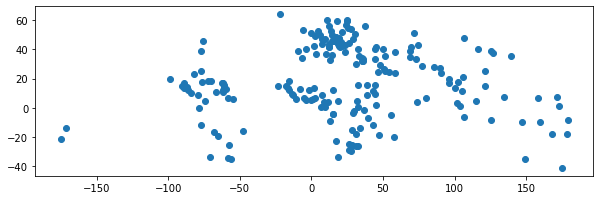

In [37]:
capital_cities = gdf.from_file('data/vector/global/capital_cities.shp')
fig, ax = plt.subplots(1, figsize=(10, 5))
capital_cities.plot(ax=ax)
plt.show()

### Creating a new data source
We can create new data sources in any format for which a driver is available in OGR.

In [38]:
json_driver = ogr.GetDriverByName('GeoJSON')
json_fn = 'data/vector/global/my_datasource.json'
if os.path.exists(json_fn):
    json_driver.DeleteDataSource(json_fn)
json_ds = json_driver.CreateDataSource(json_fn)
srs = ogr.osr.SpatialReference()
srs.ImportFromEPSG(32632)
if json_ds is None:
    sys.exit('Could not create {0}.'.format(json_fn))
layer = json_ds.CreateLayer('capital_cities', srs, ogr.wkbPoint)

In [39]:
coord_fld = ogr.FieldDefn('X', ogr.OFTReal)
coord_fld.SetWidth(8)
coord_fld.SetPrecision(3)
layer.CreateField(coord_fld)
coord_fld.SetName('Y')
layer.CreateField(coord_fld)

0

In [40]:
for field in layer.schema:
    print(field.name, field.GetTypeName())
#del json_ds

X Real
Y Real


In [41]:
layer_def = layer.GetLayerDefn()
layer_def.GetFieldCount()

2

In [42]:
feat = ogr.Feature(layer_def)
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(1.0, 2.0)
feat.SetGeometry(point)
layer.CreateFeature(feat)

0

In [43]:
def createPointFeature(layer_def, x, y):
    feat = ogr.Feature(layer_def)
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(x, y)
    feat.SetGeometry(point)
    layer.CreateFeature(feat)
    return 0

In [44]:
createPointFeature(layer_def, 1.0, 2.0)
createPointFeature(layer_def, 3.0, 5.0)
createPointFeature(layer_def, 6.0, 3.0)

0

In [45]:
layer.GetFeatureCount()

0

### Vector file formats
We define a function that will print the layers contained in a data source using its file name as input argument.

In [46]:
def print_layers(fn):
    ds = ogr.Open(fn, 0)
    if ds is None:
        raise OSError('Could not open {}'.format(fn))
    for i in range(ds.GetLayerCount()):
        layer = ds.GetLayer(i)
        print('{0}: {1}'.format(i, layer.GetName()))

An Esri shape file can contain only one layer

In [47]:
fn = 'data/vector/global/ne_50m_populated_places.shp'
print_layers(fn)

0: ne_50m_populated_places


An SQLite database can contain several layers

In [48]:
fn = 'data/vector/global/natural_earth_50m.sqlite'
print_layers(fn)

0: countries
1: populated_places


In [49]:
ds = ogr.Open(fn)
pp_layer = ds.GetLayer('populated_places')

ESRI shape files can be stored in a folder. Each shape file defines a layer. 

In [50]:
fn = 'data/vector/US'
print_layers(fn)

0: citiesx020
1: cities_48
2: cities_albers
3: countyp010
4: roadtrl020
5: statep010
6: states_48
7: us_volcanos
8: us_volcanos_albers
9: volcanx020
10: wtrbdyp010


CSV files in a folder can be used to represent different layers.

In [51]:
fn = 'data/vector/US/csv'
print_layers(fn)

0: cities
1: volcanoes


ESRI file geodatabase

In [52]:
fn = 'data/vector/global/natural_earth.gdb'
print_layers(fn)

0: countries_10m
1: populated_places_10m
2: countries_110m
3: populated_places_110m


In [53]:
ds = ogr.Open(fn)
layer = ds.GetLayer('countries_10m')

We copy a layer from an ESRI geodatabase to a shape file.

In [54]:
gdb_ds = ogr.Open('data/vector/global/natural_earth.gdb')
gdb_lyr = gdb_ds.GetLayerByName('countries_110m')
shp_ds = ogr.Open('data/vector/global', 1)
shp_ds.CopyLayer(gdb_lyr, 'copy_countries_110m')
del shp_ds, gdb_ds

### Filtering data with OGR
We use the OGR library to filter features in a data source, e.g. a shapefile.

In [55]:
ds = ogr.Open('data/vector/global')
country_layer = ds.GetLayer('ne_50m_admin_0_countries')
featureCount = country_layer.GetFeatureCount()
print('Number of features %d'%(featureCount))
#for feature in country_layer:
#    print(feature.geometry().GetY())

Number of features 241


In [56]:
for field in country_layer.schema:
    print(field.name, field.GetTypeName())

scalerank Integer
featurecla String
labelrank Real
sovereignt String
sov_a3 String
adm0_dif Real
level Real
type String
admin String
adm0_a3 String
geou_dif Real
geounit String
gu_a3 String
su_dif Real
subunit String
su_a3 String
brk_diff Real
name String
name_long String
brk_a3 String
brk_name String
brk_group String
abbrev String
postal String
formal_en String
formal_fr String
note_adm0 String
note_brk String
name_sort String
name_alt String
mapcolor7 Real
mapcolor8 Real
mapcolor9 Real
mapcolor13 Real
pop_est Real
gdp_md_est Real
pop_year Real
lastcensus Real
gdp_year Real
economy String
income_grp String
wikipedia Real
fips_10 String
iso_a2 String
iso_a3 String
iso_n3 String
un_a3 String
wb_a2 String
wb_a3 String
woe_id Real
adm0_a3_is String
adm0_a3_us String
adm0_a3_un Real
adm0_a3_wb Real
continent String
region_un String
subregion String
region_wb String
name_len Real
long_len Real
abbrev_len Real
tiny Real
homepart Real


### Attribute filtering
We select some features by one of their attibutes.

In [57]:
country_layer.SetAttributeFilter("continent = 'Asia'")

0

In [58]:
country_layer.GetFeatureCount()

53

In [59]:
country_layer.GetFeature(7).GetField('name')

'United Arab Emirates'

In [60]:
country_layer.SetAttributeFilter("continent = 'South America'")

0

In [61]:
country_layer.GetFeatureCount()

13

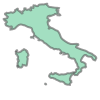

In [68]:
country_layer.SetAttributeFilter("name = 'Italy'")
feat = country_layer.GetNextFeature()
italy = feat.geometry().Clone()
wkt.loads(italy.ExportToIsoWkt())

### Spatial filtering
We select the cities that lie within a country's boundary

In [69]:
city_layer = ds.GetLayer('ne_50m_populated_places')
city_layer.GetFeatureCount()

21

In [70]:
city_layer.SetSpatialFilter(italy) # set the spatial filter
city_layer.GetFeatureCount()

21

In [71]:
for city in city_layer:
    print(city.name, field.GetTypeName())

Potenza String
Campobasso String
Aosta String
Vatican City String
Bologna String
Cagliari String
Catanzaro String
Bari String
L'Aquila String
Ancona String
Perugia String
Trieste String
Trento String
Turin String
Genoa String
Florence String
Catania String
Palermo String
Naples String
Milan String
Rome String


We can further select the cities by attributes, e.g. by their population

In [72]:
city_layer.SetAttributeFilter('POP2010 > 1000')
city_layer.GetFeatureCount()

4

We can use a bounding box to spatially filter the features. We remove the attribute filter than we apply a spatial filter using a bounding box

In [73]:
city_layer.SetAttributeFilter(None)
city_layer.SetSpatialFilter(None)
min_long = 6.671
min_lat = 35.494
max_long = 18.337
max_lat = 47.095
city_layer.SetSpatialFilterRect(min_long, min_lat, max_long, max_lat)
print(city_layer.GetName()) # to be completed without using Garrard's script

ne_50m_populated_places


Then we apply an attribute filter to select the cities with a population above 1 million.

In [74]:
city_layer.SetAttributeFilter('POP2010 > 1000')
#pb.print_attributes(city_layer, 0, ['NAME', 'ADM0NAME', 'POP2010'], geom=False) # to be completed without using Garrard's script

0

### SQL spatial and attribute filtering
We filter cities by two attributes and then by a geometry. In particular we select cities that have a population above 1 million and lie withing the Italian boundary.

In [75]:
ds = ogr.Open(r'data\vector\global')
country_layer = ds.GetLayer('ne_50m_admin_0_countries')
country_layer.SetAttributeFilter("name = 'Italy'")
feat = country_layer.GetNextFeature()
country = feat.geometry().Clone() # we use a country's geometry for spatial filtering
sql = "SELECT NAME, POP2010 FROM ne_50m_populated_places WHERE POP2010 > 1000 ORDER BY POP2010 DESC"
layer = ds.ExecuteSQL(sql, country)
#pb.print_attributes(layer) # to be completed without using Garrard's script

### Reading ESRI shape files using the Python Shapefile Library

In [76]:
shp_path = 'data/vector/US/cities_48.shp'
sf = shp.Reader(shp_path)
len(sf)

34610

In [77]:
sf.shapeType

1

In [78]:
shapes = sf.shapes(); len(shapes)

34610

In [79]:
print(sf)

shapefile Reader
    34610 shapes (type 'POINT')
    34610 records (12 fields)


In [80]:
sf.shapeType == shp.POLYGON

False

In [81]:
rec = sf.record(3)
rec[1:3]

['Populated Place', 'Frenchville']

In [82]:
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['CITIESX020', 'N', 11, 0],
 ['FEATURE', 'C', 27, 0],
 ['NAME', 'C', 48, 0],
 ['POP_RANGE', 'C', 21, 0],
 ['POP_2000', 'N', 8, 0],
 ['FIPS55', 'C', 5, 0],
 ['COUNTY', 'C', 55, 0],
 ['FIPS', 'C', 5, 0],
 ['STATE', 'C', 2, 0],
 ['STATE_FIPS', 'C', 2, 0],
 ['DISPLAY', 'N', 1, 0]]

In [83]:
sf.records()[:2]

[Record #0: [366, 'Populated Place', 'Saint David', 'Undetermined', -99999, '64955', 'Aroostook County', '23003', 'ME', '23', 0],
 Record #1: [367, 'Populated Place', 'Madawaska', 'Undetermined', -99999, '42485', 'Aroostook County', '23003', 'ME', '23', 1]]

In [84]:
def shapefile2pandas(sf):
    """
    Converts a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [85]:
df = shapefile2pandas(sf)
df.shape

(34610, 12)

In [86]:
df.sample(5)

,CITIESX020,FEATURE,NAME,POP_RANGE,POP_2000,FIPS55,COUNTY,FIPS,STATE,STATE_FIPS,DISPLAY,coords
8953,9319,Populated Place,Sturtevant,"0 - 9,999",5287,77925,Racine County,55101,WI,55,0,"[[-87.89451599121094, 42.69807815551758]]"
883,1249,Populated Place,Edwall,Undetermined,-99999,20785,Lincoln County,53043,WA,53,0,"[[-117.95293426513672, 47.50433349609375]]"
179,545,Populated Place,Silverton,Undetermined,-99999,64470,Snohomish County,53061,WA,53,0,"[[-121.56964874267578, 48.07830810546875]]"
23132,23609,County Seat,Bardwell,"0 - 9,999",799,03664,Carlisle County,21039,KY,21,0,"[[-89.00978088378906, 36.8706169128418]]"
28765,29300,Populated Place,Chula Vista,"100,000 - 249,999",173556,13392,San Diego County,06073,CA,06,0,"[[-117.08419036865234, 32.640052795410156]]"


In [87]:
df.COUNTY

0        Aroostook County
1        Aroostook County
2        Aroostook County
3        Aroostook County
4        Aroostook County
               ...       
34605       Cayuga County
34606     Onondaga County
34607       Greene County
34608       Warren County
34609      Orleans County
Name: COUNTY, Length: 34610, dtype: object

In [88]:
df[df.COUNTY == 'Orleans County'][:3]

,CITIESX020,FEATURE,NAME,POP_RANGE,POP_2000,FIPS55,COUNTY,FIPS,STATE,STATE_FIPS,DISPLAY,coords
1237,1603,Populated Place,Derby Line,"0 - 9,999",776,17500,Orleans County,50019,VT,50,0,"[[-72.09799194335938, 45.00236892700195]]"
1278,1644,Populated Place,Derby Center,"0 - 9,999",670,17425,Orleans County,50019,VT,50,0,"[[-72.13287353515625, 44.94782638549805]]"
1296,1662,Populated Place,North Troy,"0 - 9,999",593,52075,Orleans County,50019,VT,50,0,"[[-72.39983367919922, 44.994483947753906]]"


## Manipulating geometries with OGR
We want to represent a house with a small garden and other features. We start by representing some features as points. A point feature has a geometry and attributes such as the coordinates. A point can have only one pair of coordinates.

### Point geometry

In [89]:
firepit = ogr.Geometry(ogr.wkbPoint)
firepit.AddPoint(59.5, 11.5)
x, y = firepit.GetX(), firepit.GetY(); x, y

(59.5, 11.5)

### Multipoint geometry
A multipoint geometry is a collection of points that are associated to a feature.

In [91]:
faucets = ogr.Geometry(ogr.wkbMultiPoint)
faucet = ogr.Geometry(ogr.wkbPoint)
faucet.AddPoint(67.5, 16)
faucets.AddGeometry(faucet)
faucet.AddPoint(73, 31)
faucets.AddGeometry(faucet)
faucet.AddPoint(81, 24.5)
faucets.AddGeometry(faucet) 
faucets_json = faucets.ExportToJson()
faucets_gdf = gpd.read_file(faucets_json)

(66.825, 81.675, 15.25, 31.75)

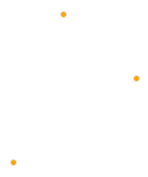

In [94]:
fig, ax = plt.subplots(1, figsize=(3, 3))
faucets_gdf.plot(color='orange', ax=ax, edgecolor='0.9')
ax.axis('off')

### Line
A line has a geometry to which two or more points are added.

In [120]:
sidewalk = ogr.Geometry(ogr.wkbLineString)
sidewalk.AddPoint(54, 37)
sidewalk.AddPoint(62, 35.5)
sidewalk.AddPoint(70.5, 38)
sidewalk.AddPoint(74.5, 41.5)
sidewalk_json = sidewalk.ExportToJson()
print(sidewalk_json)

{ "type": "LineString", "coordinates": [ [ 54.0, 37.0, 0.0 ], [ 62.0, 35.5, 0.0 ], [ 70.5, 38.0, 0.0 ], [ 74.5, 41.5, 0.0 ] ] }


We import the GeoJson data into a GeoPandas dataframe

In [126]:
sidewalk_gdf = gpd.read_file(sidewalk_json)

(52.975, 75.525, 35.2, 41.8)

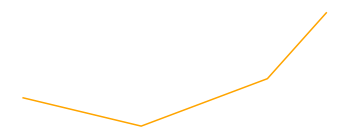

In [127]:
fig, ax = plt.subplots(1, figsize=(6, 5))
sidewalk_gdf.plot(color='orange', ax=ax, edgecolor='0.9')
ax.axis('off')

In [128]:
vertices = sidewalk.GetPoints()
print(vertices)

[(54.0, 37.0, 0.0), (62.0, 35.5, 0.0), (70.5, 38.0, 0.0), (74.5, 41.5, 0.0)]


In [129]:
vertices[2:2] = [(66.5, 35)]
print(vertices)

[(54.0, 37.0, 0.0), (62.0, 35.5, 0.0), (66.5, 35), (70.5, 38.0, 0.0), (74.5, 41.5, 0.0)]


### Multiline
A multiline is a collection of lines.

In [131]:
line1 = ogr.Geometry(ogr.wkbLineString)
line1.AddPoint(61.5, 29)
line1.AddPoint(63, 20)
line1.AddPoint(62.5, 16)
line1.AddPoint(60, 13)
line2 = ogr.Geometry(ogr.wkbLineString)
line2.AddPoint(60.5, 12)
line2.AddPoint(68.5, 13.5)
line3 = ogr.Geometry(ogr.wkbLineString)
line3.AddPoint(69.5, 33)
line3.AddPoint(80, 33)
line3.AddPoint(86.5, 22.5)
multiline = ogr.Geometry(ogr.wkbMultiLineString)
multiline.AddGeometry(line1)
multiline.AddGeometry(line2)
multiline.AddGeometry(line3)
multiline_json = multiline.ExportToJson()
multiline_gdf = gpd.read_file(multiline_json)

(58.675, 87.825, 10.95, 34.05)

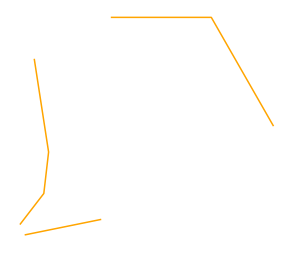

In [133]:
fig, ax = plt.subplots(1, figsize=(5, 5))
multiline_gdf.plot(color='orange', ax=ax, edgecolor='0.9')
ax.axis('off')

### Polygon
A polygon can have one or more closed paths, also called ring. This happens because a polygon can have a hole that can be represented by another polygon inside the first one.

In [134]:
ring = ogr.Geometry(ogr.wkbLinearRing)
ring.AddPoint(58, 38.5)
ring.AddPoint(53, 6)
ring.AddPoint(99.5, 19)
ring.AddPoint(73, 42)
yard = ogr.Geometry(ogr.wkbPolygon)
yard.AddGeometry(ring)
yard.CloseRings()
yard_json = yard.ExportToJson()
yard_gdf = gpd.read_file(yard_json)

(50.675, 101.825, 4.2, 43.8)

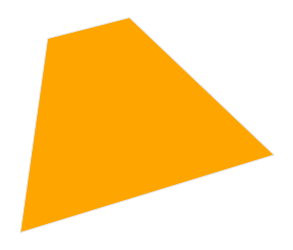

In [135]:
fig, ax = plt.subplots(1, figsize=(5, 5))
yard_gdf.plot(color='orange', ax=ax, edgecolor='0.9')
ax.axis('off')

### Polygon with hole
A polygon with holes is a geometry made up of one external polygon, for the external border, and one or more other polygons inside it for the internal borders. As an example we will add a closed path, a house, to the polygon that we have already created.

In [136]:
house = ogr.Geometry(ogr.wkbLinearRing)
house.AddPoint(67.5, 29)
house.AddPoint(69, 25.5)
house.AddPoint(64, 23)
house.AddPoint(69, 15)
house.AddPoint(82.5, 22)
house.AddPoint(76, 31.5)
yard.AddGeometry(house)
yard.CloseRings()
yard_json = yard.ExportToJson()
yard_gdf = gpd.read_file(yard_json)

(50.675, 101.825, 4.2, 43.8)

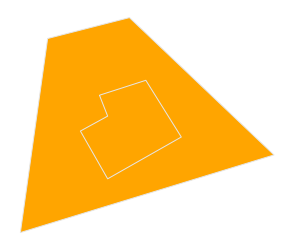

In [139]:
fig, ax = plt.subplots(1, figsize=(5, 5))
yard_gdf.plot(color='orange', ax=ax, edgecolor='0.9')
ax.axis('off')

## Vector analysis with OGR
In this section we use topological operators available from OGR.

In [140]:
water_ds = ogr.Open('data/vector/US/wtrbdyp010.shp')
water_layer = water_ds.GetLayer(0)
water_layer.SetAttributeFilter('WaterbdyID = 1011327')
marsh_feature = water_layer.GetNextFeature()
marsh_geometry = marsh_feature.geometry().Clone()
marsh_json = marsh_geometry.ExportToJson()
marsh_gdf = gpd.read_file(marsh_json)

(-90.05351526934993,
 -89.14994916964991,
 29.152351217250065,
 30.222804331750048)

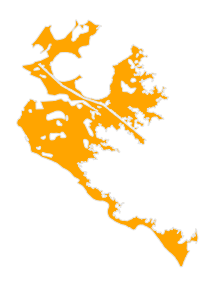

In [141]:
fig, ax = plt.subplots(1, figsize=(5, 5))
marsh_gdf.plot(color='orange', ax=ax, edgecolor='0.9')
ax.axis('off')

In [144]:
nola_ds = ogr.Open(r'data\vector\Louisiana\NOLA.shp')
nola_layer = nola_ds.GetLayer(0)
nola_feature = nola_layer.GetNextFeature()
nola_geometry = nola_feature.geometry().Clone()
nola_json = nola_geometry.ExportToJson()
nola_gdf = gpd.read_file(nola_json)

(-90.1657800161176, -89.59930409436842, 29.848918445570433, 30.216018360077328)

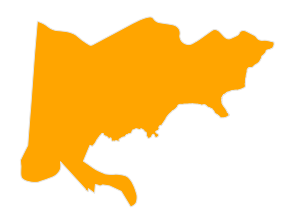

In [145]:
fig, ax = plt.subplots(1, figsize=(5, 5))
nola_gdf.plot(color='orange', ax=ax, edgecolor='0.9')
ax.axis('off')

In [148]:
intersection_geometry = marsh_geometry.Intersection (nola_geometry)
intersection_json = intersection_geometry.ExportToJson()
intersection_gdf = gpd.read_file(intersection_json)

(-90.00556320429993, -89.61070675769994, 29.97105356561693, 30.18381850563734)

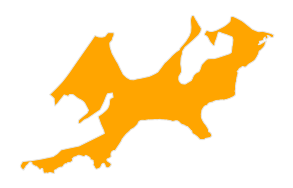

In [149]:
fig, ax = plt.subplots(1, figsize=(5, 5))
intersection_gdf.plot(color='orange', ax=ax, edgecolor='0.9')
ax.axis('off')

In [34]:
water_layer.SetAttributeFilter("Feature != 'Lake'")
water_layer.SetSpatialFilter(nola_geometry)
wetlands_area = 0
for feature in water_layer:
    intersect = feature.geometry().Intersection (nola_geometry)
    wetlands_area += intersect.GetArea()
pcnt = wetlands_area / nola_geometry.GetArea()
print('{:.1%} of New Orleans is wetland'.format(pcnt))

28.7% of New Orleans is wetland


A different way to get the same result (but it doesn't seem to work)

In [150]:
water_layer.SetAttributeFilter("Feature != 'Lake'")
memory_driver = ogr.GetDriverByName('Memory')
temp_ds = memory_driver.CreateDataSource('temp')
temp_layer = temp_ds.CreateLayer('temp')
nola_layer.Intersection(water_layer, temp_layer)
sql = 'SELECT SUM(OGR_GEOM_AREA) AS area FROM temp'
layer = temp_ds.ExecuteSQL (sql)
pcnt = layer.GetFeature(0).GetField('area') / nola_geometry.GetArea()
print('{:.1%} of New Orleans is wetland'.format(pcnt))

7910.9% of New Orleans is wetland


### Proximity tools
We want to know how many US cities lie within a certain distance from volcanos. We begin by opening a layer about the US cities and a layer about volcanos in the US.

In [151]:
shp_ds = ogr.Open('data/vector/US')
volcano_layer = shp_ds.GetLayer('us_volcanos_albers')
cities_layer = shp_ds.GetLayer('cities_albers')
print('Cities: {}'.format(cities_layer.GetFeatureCount()))
print('Volcanos: {}'.format(volcano_layer.GetFeatureCount()))

Cities: 35432
Volcanos: 155


We need a layer that will contain the volcanos with a buffer area around them. The layer will be in memory since we need it only to compute the number of cities that lie within the buffer area of a volcano.

In [152]:
memory_driver = ogr.GetDriverByName('memory')
memory_ds = memory_driver.CreateDataSource('temp')
buffer_layer = memory_ds.CreateLayer('buffer')
buffer_feature = ogr.Feature(buffer_layer.GetLayerDefn())

We extract the volcanos' geometries, compute the buffer areas around them and we add those buffer areas to the temporary layer

In [153]:
distance = 16000 # 1 mile
for volcano_feature in volcano_layer:
    buffer_geometry = volcano_feature.geometry().Buffer(distance)
    buffer_feature.SetGeometry(buffer_geometry)
    buffer_layer.CreateFeature(buffer_feature)

We need another temporary (in memory) layer to store the result of the intersection between the volcanos with their buffer areas and the cities to know how many of the latter lie within a volcano.

In [154]:
result_layer = memory_ds.CreateLayer('result')
buffer_layer.Intersection (cities_layer, result_layer)

0

In [155]:
print('Cities: {}'.format(result_layer.GetFeatureCount()))

Cities: 83


We can perform the same task following a different approach. We use a multipolygon to store all the volcanos' buffer geometries, then we apply a method, UnionCascaded, to create the union of the volcano buffer areas to be used as a filter for cities.

In [156]:
volcano_layer.ResetReading()
multipoly = ogr.Geometry(ogr.wkbMultiPolygon)

for volcano_feature in volcano_layer:
    buffer_geometry = volcano_feature.geometry().Buffer(distance)
    multipoly.AddGeometry(buffer_geometry)

cities_layer.SetSpatialFilter(multipoly.UnionCascaded ())
print('Cities: {}'.format(cities_layer.GetFeatureCount()))

Cities: 78


As we can see, the number of cities is lower with this second method. This happens because with the first method some cities lie within more than one volcano buffer area and so they are counted more than once.

Now we look for the Mount St. Helens nearest city and we compute its distance from the volcano

In [157]:
distance = 32000 # 20 miles
volcano_layer.SetAttributeFilter("NAME = 'St. Helens'")
feature = volcano_layer.GetNextFeature()
st_helens = feature.geometry().Clone()
buffer_geometry = st_helens.Buffer(distance)
cities_layer.SetSpatialFilter(buffer_geometry)
print('Cities: {}'.format(cities_layer.GetFeatureCount()))

Cities: 1


In [158]:
feature_city = cities_layer.GetNextFeature()
name = feature_city.GetField('NAME')
print(name)

Cougar


In [159]:
meters = round(st_helens.Distance(feature_city.geometry().Clone()))
miles = meters / 1600
print('{} meters ({} miles)'.format(meters, miles))

18920 meters (11.825 miles)


### Suitability analysis: locating areas suitable for wind farms
We look for areas suitable for wind farms. These areas must satisfy two criteria: 

1. be classified as 3 or more for wind
2. population density less than 0.5 persons per square kilometer.

First we get the population density from the 'popsqkm' field of the California census data. 

In [95]:
census_fn = 'data/vector/US/California/ca_census_albers.shp'
census_ds = ogr.Open(census_fn, True)
census_layer = census_ds.GetLayer()
print('Population density: {} persons/sqkm'.format(census_layer[0].GetField('popsqkm')))
#for row in census_layer:
#    popsqkm = row.GetField('popsqkm')
#    print('Population density: {} persons/sqkm'.format(popsqkm))
print('Population density: {} persons/sqkm'.format(census_layer[0].GetField(7)))

Population density: 2830.2167844165187 persons/sqkm
Population density: Census Tract 4251.03, Alameda County, California persons/sqkm


2nd, we get the geometry of the Imperial county for which we want to assess the suitabilty for wind farms.

In [96]:
county_fn = 'data/vector/US/countyp010.shp'
county_ds = ogr.Open(county_fn)
county_layer = county_ds.GetLayer()
county_layer.SetAttributeFilter("COUNTY ='Imperial County'")
feat = county_layer.GetNextFeature()
county_geom = feat.geometry().Clone()
del county_ds

We have to project the county data onto the same reference system used for the census data, then we can spatially filter the census data to get the Imperial county census data to finally select the areas with a population density below 0.5 persons per square meter.

In [97]:
county_geom.TransformTo(census_layer.GetSpatialRef())
census_layer.SetSpatialFilter(county_geom)
census_layer.SetAttributeFilter('popsqkm < 0.5')
census_layer.GetFeatureCount()

2

Now we get the wind data filtering the areas that are classified 3 or above

In [98]:
wind_fn = 'data/vector/US/California/california_50m_wind_albers.shp'
wind_ds = ogr.Open(wind_fn)
wind_layer = wind_ds.GetLayer()
wind_layer.SetAttributeFilter('WPC >= 3')
wind_layer.GetFeatureCount()

124244

Before applying the two filters for our suitability assessment we create a new data source (Esri shapefile) where we will store the results. The data source has two attributes: wind and popsqkm.

In [99]:
suitability_fn = 'data/vector/US/California/wind_farm.shp'
suitability_ds = ogr.GetDriverByName('ESRI Shapefile').CreateDataSource(suitability_fn)
suitability_layer = suitability_ds.CreateLayer('wind_farm', wind_layer.GetSpatialRef(), ogr.wkbPolygon)
suitability_layer.CreateField(ogr.FieldDefn('wind', ogr.OFTInteger))
suitability_layer.CreateField(ogr.FieldDefn('popsqkm', ogr.OFTReal))
suitability_row = ogr.Feature(suitability_layer.GetLayerDefn())

We iterate through the areas that meet the suitability criteria saving the data in the suitability data source

In [100]:
for census_row in census_layer:
    census_geom = census_row.geometry()
    census_geom = census_geom.Intersection(county_geom)
    wind_layer.SetSpatialFilter(census_geom)
    print('Intersecting census tract with {0} wind polygons'.format(wind_layer.GetFeatureCount()))
    if wind_layer.GetFeatureCount() > 0:
        suitability_row.SetField('popsqkm', census_row.GetField('popsqkm'))
        for wind_row in wind_layer:
            wind_geom = wind_row.geometry()
            is_intersect = census_geom.Intersect(wind_geom)
            if is_intersect:
                suitability_row.SetField('wind', wind_row.GetField('WPC'))
                suitability_row.SetGeometry(census_geom.Intersection(wind_geom))
                suitability_layer.CreateFeature(suitability_row)

Intersecting census tract with 36 wind polygons
Intersecting census tract with 957 wind polygons


In [101]:
suitability_layer.GetFeatureCount()
del suitability_ds

### Tracking animals: Galapagos albatrosses
In this example we use a dataset from a [research study](https://www.datarepository.movebank.org/handle/10255/move.331) that contains data about the movements of albatrosses between the Galapagos islands and the coast of Peru. The original dataset is a CSV file. We will first create a shapefile with a spatial reference system and two attributes, tag_id and timestamp, then we will copy the data from the CSV file to the shapefile.

In [110]:
shp_fn = r'data/vector/global/Galapagos/albatross_dd.shp'
shp_ds = ogr.GetDriverByName('ESRI Shapefile').CreateDataSource(shp_fn)
sr = osr.SpatialReference()
sr.ImportFromEPSG(4326)
shp_lyr = shp_ds.CreateLayer('albatross_dd', sr, ogr.wkbPoint)
shp_lyr.CreateField(ogr.FieldDefn('tag_id', ogr.OFTString))
shp_lyr.CreateField(ogr.FieldDefn('timestamp', ogr.OFTString))
shp_row = ogr.Feature(shp_lyr.GetLayerDefn())

In [111]:
csv_fn = 'data/vector/global/Galapagos/Galapagos Albatrosses.csv'
csv_ds = ogr.Open(csv_fn)
csv_lyr = csv_ds.GetLayer()
for csv_row in csv_lyr:
    x = csv_row.GetFieldAsDouble('location-long')
    y = csv_row.GetFieldAsDouble('location-lat')
    shp_pt = ogr.Geometry(ogr.wkbPoint)
    shp_pt.AddPoint(x, y)
    tag_id = csv_row.GetField('individual-local-identifier')
    timestamp = csv_row.GetField('timestamp')
    shp_row.SetGeometry(shp_pt)
    shp_row.SetField('tag_id', tag_id)
    shp_row.SetField('timestamp', timestamp)
    shp_lyr.CreateFeature(shp_row)

In [115]:
galapagos_gdf = gpd.read_file(shp_fn)
#fig, ax = plt.subplots(1, figsize=(10, 10))
#galapagos_gdf.plot(color='orange', ax=ax)
#ax.axis('off')

The next step is to compute for each albastros the distances between the places in which it has been observed, in time order. 

In [116]:
def get_unique(datasource, layer_name, field_name):
    sql = 'SELECT DISTINCT {0} FROM {1}'.format(field_name, layer_name)
    lyr = datasource.ExecuteSQL (sql)
    values = []
    for row in lyr:
        values.append(row.GetField(field_name))
    datasource.ReleaseResultSet(lyr)
    return values

For each bird it is possible to determine the areas that are mostly visited by computing the convex hull from the observations.

## Spatial reference systems
A spatial reference system (or coordinate reference system) consists of three elements

1. Coordinate system
2. Datum
3. Projection

A datum defines the shape of the Earth: sphere, ellipsoid, geoid. A (geographic) coordinate system is a reference system with the origin at the center of the Earth. An example of datum is the World Geodetic System 1984, or WGS84. The (geographic) coordinates of a point on the datum's surface can be projected on a 2D surface, a plane. There exist many projections that can be classified depending on the property that is preserved after a projection from 3D to 2D. Conformal projections preserve the angles. Universal Transverse Mercator (UTM) is a conformal projection. Equal-area projections preserve what is stated in its name, one example is the Lambert projection. The Azimuthal-equidistance projection preserves the distance. The spatial reference system must always be included with the data, otherwise it would be impossible to say to which location on Earth a coordinate pair refers to.

In [117]:
path = 'data/vector/US/states_48.shp'
ds = ogr.Open(path)
sr = ds.GetLayer().GetSpatialRef()
print(sr)

GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS 1980",6378137,298.257222101,
            AUTHORITY["EPSG","7019"]],
        AUTHORITY["EPSG","6269"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4269"]]


This reference system has a datum, the North American Datum 1983, but is not projected. Spatial reference system like this are called 'geographic' or 'unprojected'.

In [118]:
print(ds.GetLayer().GetSpatialRef().GetAttrValue('PROJCS'))

None


We can use GeoPandas to open the dataset so that it will be easier to plot the data.

In [119]:
us48_gdf = gpd.read_file(path)
us48_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

The spatial reference system is not projected but if we plot a 2D map Python will choose one. 

<AxesSubplot:title={'center':'Continental US - Geographic Reference System WGS84'}>

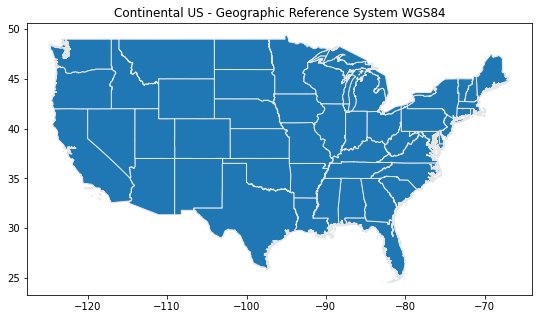

In [121]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.set_title('Continental US - Geographic Reference System WGS84')
us48_gdf.plot(ax=ax, edgecolor='0.9')

### Creating a spatial reference system
The [EPSG](https://epsg.io) has a list of spatial reference systems. We can import a spatial reference system to be used in a layer.

In [122]:
sr = osr.SpatialReference()
sr.ImportFromEPSG(26912)

0

This patial reference system is a projected one

In [123]:
sr.GetAttrValue('PROJCS')

'NAD83 / UTM zone 12N'

Once we have a spatial reference we can create a data source and a layer adding the spatial reference to it.

In [124]:
driver = ogr.GetDriverByName('ESRI Shapefile')
ds = driver.CreateDataSource(r'data/vector/testdata.shp')
lyr = ds.CreateLayer('counties', sr, ogr.wkbPolygon)

We can add features to a layer, paying attention that their coordinates are valid according to the layer's spatial reference. In case a feauture has a different spatial reference than the layer, we have to transform its coordinates before adding that feature to the layer.

<AxesSubplot:title={'center':'World Map - Geographic Reference System WGS84'}>

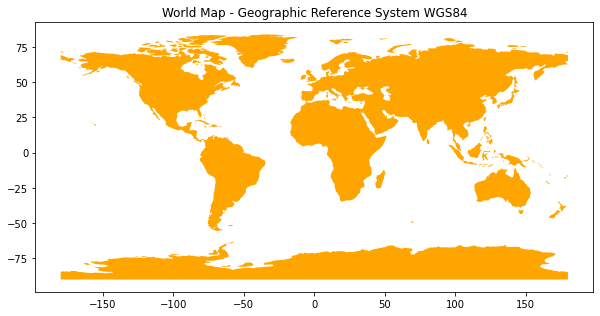

In [125]:
world_fn = 'data/vector/global/ne_110m_land_1p.shp'
world = gpd.read_file(world_fn)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.set_title('World Map - Geographic Reference System WGS84')
world.plot(color='orange', ax=ax)

The spatial reference used by the world dataset is WGS84 and it's not projected as we can see from the description

In [126]:
world_ds = ogr.Open(world_fn)
print(world_ds.GetLayer().GetSpatialRef())

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]


## Reprojecting an entire layer
We want to reproject, that is change the reference system

In [134]:
#fig, ax = plt.subplots(1, figsize=(15, 10))
ax.set_title('World Map - Projected Reference System EPSG:3035')
world_epsg3395 = world.to_crs(epsg=3395)
#print(world_epsg3395.GetSpatialRef())
#world_epsg3395.plot(color='orange', ax=ax)

## Convert coordinates
We can create a feature, e.g. a point with its coordinate pair, latitude and longtude, and assign the WGS84 spatial reference to it.

In [135]:
sr_wgs84 = osr.SpatialReference()
sr_wgs84.ImportFromEPSG(4326)

0

In [136]:
eiffel_tower = ogr.Geometry(ogr.wkbPoint) 
eiffel_tower.AddPoint(2.294694, 48.858093)
eiffel_tower.AssignSpatialReference(sr_wgs84)

We can transform our point's coordinates to another reference system, e.g the one used by Google Maps [EPSG:3857](https://epsg.io/3857)

In [137]:
web_mercator_sr = osr.SpatialReference()
web_mercator_sr.ImportFromEPSG(3857)

0

In [138]:
eiffel_tower.TransformTo(web_mercator_sr)
eiffel_tower_wkt = eiffel_tower.ExportToWkt()
eiffel_tower_wkt

'POINT (5438858.0338904 255512.483732941 0)'

### Great circle calculation
We use [pyproj](https://pyproj4.github.io/pyproj/stable/index.html) to compute the distance between two cities on the ellipsoid.

In [140]:
la_lat, la_lon = 34.0500, -118.2500
berlin_lat, berlin_lon = 52.5167, 13.3833
geod = pyproj.Geod(ellps='WGS84')
forward, back, dist = geod.inv(la_lon, la_lat, berlin_lon, berlin_lat)
print('forward: {}\nback: {}\ndist: {} km'.format(forward, back, dist / 1000))

forward: 27.23284045673669
back: -38.49148498662069
dist: 9331.934878166698 km


## References
* [Smith - Geographic vs Projected Coordinate Systems](https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/gcs_vs_pcs/)
* [Karney - Algorithms for geodesics](https://arxiv.org/abs/1109.4448)
* [Institute for Environment and Sustainability - Map Projections for Europe](http://mapref.org/LinkedDocuments/MapProjectionsForEurope-EUR-20120.pdf)
* [Tenkanen - Map projections](https://automating-gis-processes.github.io/CSC/notebooks/L2/projections.html)